# Pre-trained models and transfer learning

Training CNNs can take a lot of time and a lot of data is required for that task. Much of the time is spent to experimenting to find the best low-level filters that a network needs to extract patterns from the images. A natural question arises - can we use a neural network trained on one dataset and adapt it to classifying different images without full training process?

This approach is called **transfer learning**, because we transfer some knowledge from one neural network model to another. In transfer learning, we typically start with a pre-trained model, which has been trained on some large image dataset, such as **ImageNet**. Those models already do a good job extracting different features from generic images, and in many cases just building a classifier on top of those extracted features can yield a good result.

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os

# In this tutorial, we will be training a lot of models. In order to use GPU memory cautiously,
# we will set tensorflow option to grow GPU memory allocation when required.
physical_devices = tf.config.list_physical_devices('GPU') 
if len(physical_devices)>0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2024-09-06 16:45:34.063238: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 16:45:34.947023: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 16:45:35.234273: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-06 16:45:37.231488: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-06 16:45:44.629878: W tensorflow/comp

In [2]:
# Load tfcv.py module
!wget -O tfcv.py -q https://github.com/MicrosoftDocs/tensorflowfundamentals/raw/main/computer-vision-tf/tfcv.py
from tfcv import *

## Cats vs. Dogs Dataset

In this unit, we will solve a real-life problem of classifying images of cats and dogs. For this reason, we will use [Kaggle Cats vs. Dogs Dataset](https://www.kaggle.com/c/dogs-vs-cats), which can also be downloaded [from Microsoft](https://www.microsoft.com/download/details.aspx?id=54765).

Let's download this dataset and extract it into `data` directory (*this process may take some time*!):

In [3]:
if not os.path.exists('data/kagglecatsanddogs_5340.zip'):
    !mkdir -p data
    !wget -P data -q https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

In [4]:
import zipfile
if not os.path.exists('data/PetImages'):
    with zipfile.ZipFile('data/kagglecatsanddogs_5340.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

Unfortunately, there are some corrupt image files in the dataset. We need to do a quick cleaning to check for corrupted files. We moved the code to verify the dataset into a module.

In [5]:
check_image_dir('data/PetImages/Cat/*.jpg')
check_image_dir('data/PetImages/Dog/*.jpg')

Corrupt image or wrong format: data/PetImages/Cat/10073.jpg
Corrupt image or wrong format: data/PetImages/Cat/10125.jpg
Corrupt image or wrong format: data/PetImages/Cat/10404.jpg
Corrupt image or wrong format: data/PetImages/Cat/10501.jpg
Corrupt image or wrong format: data/PetImages/Cat/10820.jpg
Corrupt image or wrong format: data/PetImages/Cat/10874.jpg
Corrupt image or wrong format: data/PetImages/Cat/11083.jpg
Corrupt image or wrong format: data/PetImages/Cat/11086.jpg
Corrupt image or wrong format: data/PetImages/Cat/11095.jpg
Corrupt image or wrong format: data/PetImages/Cat/11210.jpg
Corrupt image or wrong format: data/PetImages/Cat/11397.jpg
Corrupt image or wrong format: data/PetImages/Cat/1151.jpg
Corrupt image or wrong format: data/PetImages/Cat/11565.jpg
Corrupt image or wrong format: data/PetImages/Cat/11729.jpg
Corrupt image or wrong format: data/PetImages/Cat/11864.jpg
Corrupt image or wrong format: data/PetImages/Cat/11874.jpg
Corrupt image or wrong format: data/PetIm

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))


## Loading the Dataset

In the previous examples, we were loading datasets that are built into Keras. Now we will use our own dataset, which we need to load from a directory of images.

In real life, the size of image datasets can be pretty large, and one cannot rely on all data being able to fit into memory. Thus, datasets are often represented as **generators** that can return data in minibatches for training.

Keras includes a helper function `image_dataset_from_directory`, which can load images from subdirectories corresponding to different classes. This function takes care of scaling images, and it can  split dataset into train and test subsets:

In [6]:
data_dir = 'data/PetImages'
batch_size = 32
ds_train = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 13,
    image_size = (224,224),
    batch_size = batch_size
)
ds_test = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed = 13,
    image_size = (224,224),
    batch_size = batch_size
)

Found 24769 files belonging to 2 classes.
Using 19816 files for training.
Found 24769 files belonging to 2 classes.
Using 4953 files for validation.


It is important to set the same `seed` value for both calls, because it affects the split of images between train and test dataset.

The dataset automatically picks up class names from directories, and you can access them by calling:

In [7]:
ds_train.class_names

['Cat', 'Dog']

The datasets that we have loaded can be directly passed to the `fit` function to train the model. They contain both corresponding images and labels which can be looped over using the following construction:

Training batch shape: features=(32, 224, 224, 3), labels=(32,)


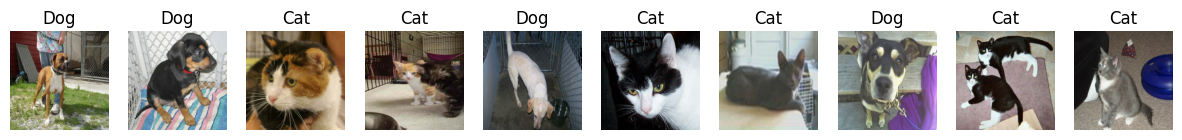

In [8]:
for x,y in ds_train:
    print(f"Training batch shape: features={x.shape}, labels={y.shape}")
    x_sample, y_sample = x,y
    break
    
display_dataset(x_sample.numpy().astype(np.uint8),np.expand_dims(y_sample,1),classes=ds_train.class_names)

> **Note**: All images in the dataset are represented as floatint point tensors with range 0-255. Before passing them to the neural network, we need to scale those values into 0-1 range. When plotting images, we either need to do the same, or convert values to the `int` type (which we do in the code above), in order to show `matplotlib` that we want to plot the original unscaled image.

## Pre-trained models

There are many pre-trained neural networks for image classification. Many of those models are available inside the `keras.applications` namespace, and even more models can be found on the Internet. Let's see how the simplest pre-trained model (VGG-16) can be loaded and used.

> In the sandbox environment, we need to explicitly load the weights of pre-trained VGG-16 network to a local directory. If you are running the code in local notebook environment, you can skip the following cell.

In [9]:
# Download model weights in the sandbox environment
!mkdir -p ~/.keras/models
!wget -P ~/.keras/models -q https://mslearntensorflowlp.blob.core.windows.net/models/vgg16_weights_tf_dim_ordering_tf_kernels.h5
!wget -P ~/.keras/models -q https://mslearntensorflowlp.blob.core.windows.net/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
!wget -P ~/.keras/models -q https://mslearntensorflowlp.blob.core.windows.net/models/imagenet_class_index.json

In [10]:

vgg = tf.keras.applications.VGG16()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [11]:
inp = keras.applications.vgg16.preprocess_input(x_sample[:1])

res = vgg(inp)
print(f"Most probable class = {tf.argmax(res,1)}")

keras.applications.vgg16.decode_predictions(res.numpy())

Most probable class = [242]
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


[[('n02108089', 'boxer', 0.9962603),
  ('n02089867', 'Walker_hound', 0.0011975806),
  ('n02093428', 'American_Staffordshire_terrier', 0.0005384792),
  ('n02087394', 'Rhodesian_ridgeback', 0.00047890132),
  ('n02089973', 'English_foxhound', 0.00036160435)]]

There are a couple of important things here:
* Before passing an input to any pre-trained network it has to be pre-processed in a certain way. This is done by calling corresponding `preprocess_input` function, which receives a batch of images, and returns their processed form. In the case of VGG-16, images are normalized, and some pre-defined average value for each channels is subtracted. That is because VGG-16 was originally trained with this pre-processing.
* Neural network is applied to the input batch, and we receive as the result a batch of 1000-element tensors that show probability of each class. We can find the most probable class number by calling `argmax` on this tensor.
* Obtained result is a [number of an `ImageNet` class](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). To make sense of this result, we can also use `decode_predictions` function, that returns top n classes together with their names.

Let's see the architecture of the VGG-16 network:

In [12]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

## GPU computations

Deep neural networks require quite a lot of computational power to run. If it is available use GPU acceleration to speed up training. Luckily, Keras automatically speeds up the computations on the GPU if it is available. We can check if TensorFlow is able to use GPU using the following code:

In [13]:
tf.config.list_physical_devices('GPU')

[]


## Extracting VGG features

If we want to use VGG-16 to extract features from our images, we need the model without the final classification layers. We can instantiate VGG-16 model without top layers using this code:

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Shape after applying VGG-16: (7, 7, 512)


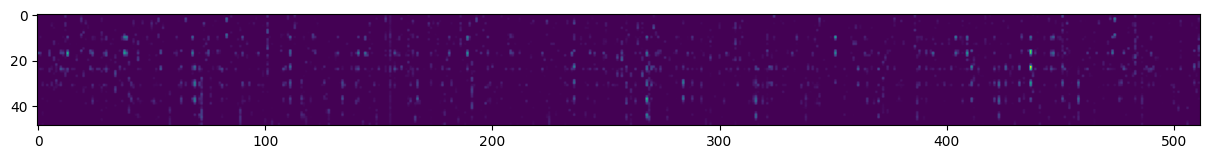

In [14]:
vgg = keras.applications.VGG16(include_top=False)

inp = keras.applications.vgg16.preprocess_input(x_sample[:1])
res = vgg(inp)
print(f"Shape after applying VGG-16: {res[0].shape}")
plt.figure(figsize=(15,3))
plt.imshow(res[0].numpy().reshape(-1,512))

The dimension of the feature tensor is 7x7x512, but in order to visualize it we had to reshape it to a 2D form.

Now let's try to see if those features can be used to classify images. Let's manually take some portion of images (50 minibatches, in our case), and pre-compute their feature vectors. We can use TensorFlow **dataset** API to do that. The `map` function takes a dataset and applies a given lambda-function to transform it. We use this mechanism to construct new datasets, `ds_features_train` and `ds_features_test`, that contain VGG-extracted features instead of original images.

In [15]:
num = batch_size*25
ds_features_train = ds_train.take(25).map(lambda x,y : (vgg(x),y))
ds_features_test = ds_test.take(10).map(lambda x,y : (vgg(x),y))

for x,y in ds_features_train:
    print(x.shape,y.shape)
    break

(32, 7, 7, 512) (32,)


We used construction `.take(50)` to limit the dataset size, to speed up our demonstration. You can of course perform this experiment on the full dataset.

Now that we have a dataset with extracted features, we can train a simple dense classifier to distinguish between cats and dogs. This network will take a feature vector of shape (7,7,512), and produce one output that corresponds either to a dog or to a cat. Because it is a binary classification, we use the `sigmoid` activation function and `binary_crossentropy` loss.

> This process can take a really long time, so you may even want to interrupt it if you are not patient. You may be wondering, why training on relatively small amount of data takes so much time! This is because the code above, which applies `vgg` feature extractor using `map`, is **lazy** - it does not in fact compute VGG features for all dataset at once, but it does it on demand. The call to VGG network happens during the training below.

In [16]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(7,7,512)),
    keras.layers.Dense(1,activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
hist = model.fit(ds_features_train, validation_data=ds_features_test)

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 401s 16s/step - acc: 0.8138 - loss: 3.2896 - val_acc: 0.9438 - val_loss: 1.4921


The result is great! We can distinguish between a cat and a dog with almost 90% accuracy! However, we have only tested this approach on a  subset of all images, because manual feature extraction takes a lot of time.

## Transfer learning using one VGG network

We can avoid manually pre-computing the features by using the original VGG-16 network as a whole during training, by adding feature extractor to our network as a first layer. 

The beauty of Keras architecture is that VGG-16 model that we have defined above can also be used as a layer in another neural network! We just need to construct a network with a dense classifier on top of it, and then train the whole network using back propagation.

In [17]:
model = keras.models.Sequential()
model.add(keras.applications.VGG16(include_top=False,input_shape=(224,224,3)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1,activation='sigmoid'))

model.layers[0].trainable = False

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,739,777 (56.23 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

This model looks like an end-to-end classification network, which takes an image and returns the class. However, the tricky thing is that we want VGG16 to act as a feature extractor, and not to be re-trained. Thus, we need to **freeze weights of convolutional feature extractor**. We can access the first layer of the network by calling `model.layers[0]`, and we just need to set `trainable` property to `False`.

> **Note**: Freezing of feature extractor weights is needed, because otherwise the untrained classifier layer can destroy the original pre-trained weights of convolutional extractor.

Notice that while the total number of parameters in our network is around 15 million, we are only training 25k parameters. All other parameters of the top-level convolutional filters are pre-trained. That is good, because we are able to fine-tune smaller number of parameters with smaller number of examples.

We will now train our network and see how good we can get. This will take a long time to train and do not worry if the execution seems frozen for some time.

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
hist = model.fit(ds_train.take(50), validation_data=ds_test.take(10))

50/50 ━━━━━━━━━━━━━━━━━━━━ 366s 7s/step - acc: 0.8194 - loss: 3.0633 - val_acc: 0.9500 - val_loss: 1.0066


We got a reasonably accurate cats vs. dogs classifier! If you want to increase the accuracy here, all you would need to do is use the full dataset. We are using a subset for time and resources purposes.

## Saving and Loading the Model

Once we have trained the model, we can save the model architecture and trained weights to a file for future use:

In [20]:
model.save('data/cats_dogs.keras')

We can then load the model from the file at any time and save the work for this training iteration.

In [21]:
model = keras.models.load_model('data/cats_dogs.keras')

## Other computer vision models

VGG-16 is one of the simplest computer vision architectures. Keras provides many more pre-trained networks. The most frequently used ones among those are **ResNet** architectures, developed by Microsoft, and **Inception** by Google.

## Takeaway

With transfer learning we were able to quickly put together a classifier for our custom object classification task and achieve high accuracy. This example was not completely fair because original VGG-16 network was pre-trained to recognize cats and dogs, and thus we were just reusing most of the patterns that were already present in the network. You can expect lower accuracy other domain-specific objects, such as details on production line in a plant or different tree leaves.

You can see that more complex tasks require higher computational power and cannot be easily solved on the CPU. In the next unit, we will try to use a more lightweight implementation to train the same model using lower compute resources, which results in just slightly lower accuracy. 